<a href="https://colab.research.google.com/github/Danilov-Aleksandr/CV_Korpus/blob/master/demo_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi

Sat Aug 29 14:13:45 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.66       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P8     9W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch
import random
import zipfile
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import os
import cv2
import time
import torchvision
from PIL import Image
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader, random_split
import albumentations 
from albumentations.pytorch import ToTensor as AT


import matplotlib.pyplot as plt

In [ ]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
seed_everything(47)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
# Распаковка датасета
# with zipfile.ZipFile('/content/dogs-vs-cats.zip', 'r') as zip_ref:
#   zip_ref.extractall('/content')

with zipfile.ZipFile('/content/drive/My Drive/Data/train.zip', 'r') as zip_ref:
  zip_ref.extractall('/content/dataset')

with zipfile.ZipFile('/content/drive/My Drive/Data/test.zip', 'r') as zip_ref:
  zip_ref.extractall('/content/dataset')

In [ ]:
train_path = '/content/dataset/train/'
test_path = '/content/dataset/test/test/'
train_list = os.listdir(train_path)
test_list = os.listdir(test_path)
sample_submission = pd.read_csv('/content/drive/My Drive/Data/sample_submission.csv')
print(len(train_list), len(test_list))

7834 1753


In [ ]:
sample_submission

,image_name,label
0,005af1c2-a59a-4182-952c-1b509e24826c.jpg,0
1,014d9286-5718-4853-b0a2-18abc58c4984.jpg,4
2,02d3e562-a9dd-4951-b9ab-7b184fa1f83a.jpg,5
3,02d9ad66-da4f-43c2-8f1c-39e6cc674289.jpg,0
4,03ab7456-ed18-40a5-808b-240b92f9b814.png,1
...,...,...
1748,fa4953a5-150d-4d4e-bd5f-2ab14c2f0202.jpg,6
1749,fb219f7e-8ba1-4722-b527-755e704c092c.jpg,0
1750,fb5fca67-0cb9-4a75-9378-554a44ef1f66.jpg,2
1751,fce9b4fb-86fc-4f30-be52-fe1129a26389.jpg,3


In [ ]:
"""PATH = '/kaggle/input/korpus-ml-1/'
train_path = PATH + "train/train/"
test_path = PATH + "test/test/"
sample_submission = pd.read_csv(PATH + "sample_submission.csv")
train_list = os.listdir(train_path)
test_list = os.listdir(test_path)
print(len(train_list), len(test_list))
sample_submission.csv"""

'PATH = \'/kaggle/input/korpus-ml-1/\'\ntrain_path = PATH + "train/train/"\ntest_path = PATH + "test/test/"\nsample_submission = pd.read_csv(PATH + "sample_submission.csv")\ntrain_list = os.listdir(train_path)\ntest_list = os.listdir(test_path)\nprint(len(train_list), len(test_list))\nsample_submission.csv'

# Кастомный датасет создаем

In [ ]:
class ChartsDataset(Dataset):
    
    def __init__(self, path, img_list, transform=None, mode='train'):
        self.path = path
        self.img_list = img_list
        self.transform=transform
        self.mode = mode
        
    def __len__(self):
        return len(self.img_list)
    
    def __getitem__(self, idx):
        image_name = self.img_list[idx]
        
        if image_name.split(".")[1] == "gif":
           gif = cv2.VideoCapture(self.path + image_name)
           _, image = gif.read()
        else:
            image = cv2.imread(self.path + image_name)
            
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        label = 0
        if "bar_chart" in image_name:
            label = 1
        elif "diagram" in image_name:
            label = 2
        elif "flow_chart" in image_name:
            label = 3
        elif "graph" in image_name:
            label = 4
        elif "growth_chart" in image_name:
            label = 5
        elif "pie_chart" in image_name:
            label = 6
        elif "table" in image_name:
            label = 7
        else:
            label = 0
            
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented["image"]
        
        if self.mode == "train":
            return image, label
        else:
            return image, image_name

In [ ]:
#зададим немного гиперпараметров
batch_size = 128
num_workers = 0
img_size = 256

In [ ]:
data_transforms = albumentations.Compose([
    albumentations.Resize(img_size, img_size),
    albumentations.Normalize(),
    AT()
    ])


data_transforms_test = albumentations.Compose([
    albumentations.Resize(img_size, img_size),
    albumentations.Normalize(),
    AT()
    ])

In [ ]:
#Инициализируем датасеты
trainset = ChartsDataset(train_path, train_list,  transform = data_transforms)
testset = ChartsDataset(test_path, test_list,  transform=data_transforms_test, mode="test")

In [ ]:
#Разделим трейновую часть на трейн и валидацию. Попробуем другой способ.
valid_size = int(len(train_list) * 0.1)
train_set, valid_set = torch.utils.data.random_split(trainset, 
                                    (len(train_list)-valid_size, valid_size))

In [ ]:
#создаем даталоадеры для всех 3х подвыборок.
trainloader = torch.utils.data.DataLoader(train_set, pin_memory=True, 
                                        batch_size=batch_size, shuffle=True)

validloader = torch.utils.data.DataLoader(valid_set, pin_memory=True, 
                                        batch_size=batch_size, shuffle=True)

testloader = torch.utils.data.DataLoader(testset, batch_size = batch_size,
                                         num_workers = num_workers)

In [ ]:
trainloader

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([3, 4, 4, 0, 7, 3, 6, 2, 7, 7, 6, 0, 1, 5, 3, 6, 5, 2, 3, 6, 4, 1, 6, 6,
        0, 1, 3, 1, 3, 6, 1, 7, 6, 7, 5, 1, 7, 3, 3, 2, 0, 7, 7, 6, 0, 4, 0, 2,
        6, 0, 6, 0, 6, 0, 6, 4, 1, 3, 0, 6, 2, 0, 3, 4, 4, 4, 6, 0, 0, 1, 7, 6,
        4, 2, 6, 0, 5, 3, 1, 2, 5, 0, 2, 7, 2, 0, 4, 1, 6, 5, 2, 0, 4, 3, 7, 6,
        5, 3, 0, 0, 3, 3, 6, 5, 1, 7, 2, 1, 7, 2, 3, 4, 6, 3, 6, 1, 2, 3, 1, 7,
        5, 3, 4, 3, 7, 6, 3, 4])


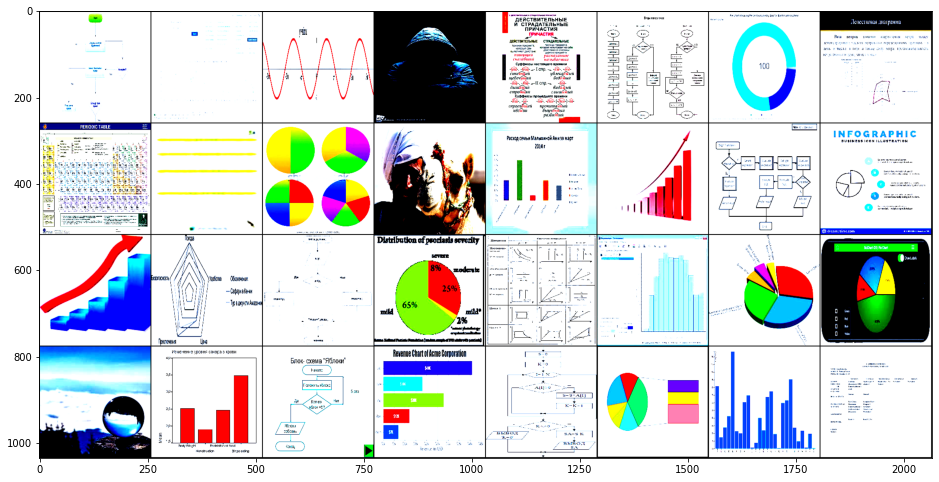

In [ ]:
samples, labels = next(iter(trainloader))
plt.figure(figsize=(16,24))
grid_imgs = torchvision.utils.make_grid(samples[:32])
np_grid_imgs = grid_imgs.numpy()
print(labels)
plt.imshow(np.transpose(np_grid_imgs, (1,2,0)))

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

# Moдель инициализируем

In [ ]:
#не забудьте включить интернет в правом меню настроек ---------------------------------------------------------------------->
model = torchvision.models.resnet50(pretrained=True, progress=True)
#тут пример как заморозить все слои, как поступить вам решайте сами, от этого тоже много зависит)

for param in model.parameters():
    param.requires_grad = False
    
in_features = model.fc.in_features
model.avgpool = nn.AdaptiveAvgPool2d(output_size=1)
model.fc = nn.Linear(in_features, 8)

In [ ]:
def validate(model, validloader, valid_size):
    correct = 0
    with torch.no_grad():
        for data, target in validloader:
            data = data.to(device=device)
            target = target.to(device=device)
            outputs = model(data)
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == target).sum().item()

    return correct / valid_size

In [ ]:
def train_model(model_conv, train_loader, valid_loader, criterion, optimizer, sheduler, n_epochs):
    model_conv.to(device)
    valid_loss_min = np.Inf
    patience = 5
    # сколько эпох ждем до отключения
    p = 0
    # иначе останавливаем обучение
    stop = False
    acc_max = 0
    # количество эпох
    for epoch in range(1, n_epochs+1):
        print(time.ctime(), 'Epoch:', epoch)

        train_loss = []

        for batch_i, (data, target) in enumerate(tqdm(train_loader)):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model_conv(data)
            loss = criterion(output, target)
            train_loss.append(loss.item())
            loss.backward()
            optimizer.step()
    # запускаем валидацию
        model_conv.eval()
        val_loss = []
        for batch_i, (data, target) in enumerate(valid_loader):
            data, target = data.to(device), target.to(device)
            output = model_conv(data)
            loss = criterion(output, target)
            val_loss.append(loss.item()) 
        
        model.eval()
        correct = 0

        acc = validate(model_conv, validloader, valid_size)
        print('validation accuracy:', acc)  
        print(f'Epoch {epoch}, train loss: {np.mean(train_loss):.4f}, valid loss: {np.mean(val_loss):.4f}.')

        valid_loss = np.mean(val_loss)
        scheduler.step(valid_loss)
        '''if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
            torch.save(model_conv.state_dict(), 'model.pt')
            valid_loss_min = valid_loss
            p = 0'''

        # проверяем как дела на валидации
        """if valid_loss > valid_loss_min:
            p += 1
            print(f'{p} epochs of increasing val loss')
            if p > patience:
                print('Stopping training')
                stop = True
                break     """ 
        if acc >= acc_max:
            print('Saving model...')
            torch.save(model_conv.state_dict(), 'model.pt')
            acc_max = acc
            p = 0

        if acc > acc_max:
            p += 1
            print(f'{p} epochs of increasing val acc')
            if p > patience:
                print('Stopping training')
                stop = True
                break     
        

        if stop:
            break
    return model_conv, train_loss, val_loss

# Параметры задаем

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1, momentum=0.9)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.8, patience=5,)

# Учим

In [ ]:
model_resnet, train_loss, val_loss = train_model(model, trainloader, validloader, criterion, 
                              optimizer, scheduler, n_epochs=15,)


  0%|          | 0/56 [00:00<?, ?it/s]

Sat Aug 29 14:22:00 2020 Epoch: 1



100%|██████████| 56/56 [02:15<00:00,  2.42s/it]


validation accuracy: 0.9029374201787995
Epoch 1, train loss: 87.2796, valid loss: 17.7484.
Saving model...



  0%|          | 0/56 [00:00<?, ?it/s]

Sat Aug 29 14:24:45 2020 Epoch: 2



100%|██████████| 56/56 [02:14<00:00,  2.40s/it]


validation accuracy: 0.9399744572158365
Epoch 2, train loss: 12.1008, valid loss: 8.8626.
Saving model...



  0%|          | 0/56 [00:00<?, ?it/s]

Sat Aug 29 14:27:29 2020 Epoch: 3



100%|██████████| 56/56 [02:14<00:00,  2.40s/it]


validation accuracy: 0.9489144316730523
Epoch 3, train loss: 6.6918, valid loss: 7.2302.
Saving model...



  0%|          | 0/56 [00:00<?, ?it/s]

Sat Aug 29 14:30:12 2020 Epoch: 4



100%|██████████| 56/56 [02:14<00:00,  2.40s/it]

  0%|          | 0/56 [00:00<?, ?it/s]

validation accuracy: 0.9476372924648787
Epoch 4, train loss: 4.7872, valid loss: 6.9863.
Sat Aug 29 14:32:56 2020 Epoch: 5



100%|██████████| 56/56 [02:14<00:00,  2.41s/it]

  0%|          | 0/56 [00:00<?, ?it/s]

validation accuracy: 0.946360153256705
Epoch 5, train loss: 3.8870, valid loss: 6.0887.
Sat Aug 29 14:35:40 2020 Epoch: 6



100%|██████████| 56/56 [02:15<00:00,  2.42s/it]

  0%|          | 0/56 [00:00<?, ?it/s]

validation accuracy: 0.9412515964240102
Epoch 6, train loss: 3.1293, valid loss: 6.2002.
Sat Aug 29 14:38:25 2020 Epoch: 7



100%|██████████| 56/56 [02:15<00:00,  2.41s/it]

  0%|          | 0/56 [00:00<?, ?it/s]

validation accuracy: 0.9412515964240102
Epoch 7, train loss: 2.3852, valid loss: 6.1806.
Sat Aug 29 14:41:09 2020 Epoch: 8



100%|██████████| 56/56 [02:15<00:00,  2.43s/it]

  0%|          | 0/56 [00:00<?, ?it/s]

validation accuracy: 0.9233716475095786
Epoch 8, train loss: 2.0826, valid loss: 7.6264.
Sat Aug 29 14:43:54 2020 Epoch: 9



100%|██████████| 56/56 [02:15<00:00,  2.41s/it]

  0%|          | 0/56 [00:00<?, ?it/s]

validation accuracy: 0.9450830140485313
Epoch 9, train loss: 2.7205, valid loss: 7.0653.
Sat Aug 29 14:46:39 2020 Epoch: 10



100%|██████████| 56/56 [02:15<00:00,  2.43s/it]


validation accuracy: 0.9514687100893997
Epoch 10, train loss: 1.4066, valid loss: 4.8710.
Saving model...



  0%|          | 0/56 [00:00<?, ?it/s]

Sat Aug 29 14:49:25 2020 Epoch: 11



100%|██████████| 56/56 [02:15<00:00,  2.42s/it]

  0%|          | 0/56 [00:00<?, ?it/s]

validation accuracy: 0.9374201787994891
Epoch 11, train loss: 1.1530, valid loss: 5.8034.
Sat Aug 29 14:52:09 2020 Epoch: 12



100%|██████████| 56/56 [02:14<00:00,  2.40s/it]

  0%|          | 0/56 [00:00<?, ?it/s]

validation accuracy: 0.9501915708812261
Epoch 12, train loss: 1.3187, valid loss: 4.9099.
Sat Aug 29 14:54:53 2020 Epoch: 13



100%|██████████| 56/56 [02:14<00:00,  2.41s/it]

  0%|          | 0/56 [00:00<?, ?it/s]

validation accuracy: 0.9374201787994891
Epoch 13, train loss: 0.6765, valid loss: 5.4794.
Sat Aug 29 14:57:37 2020 Epoch: 14



100%|██████████| 56/56 [02:14<00:00,  2.40s/it]

  0%|          | 0/56 [00:00<?, ?it/s]

validation accuracy: 0.9476372924648787
Epoch 14, train loss: 0.6034, valid loss: 4.6331.
Sat Aug 29 15:00:21 2020 Epoch: 15



100%|██████████| 56/56 [02:14<00:00,  2.40s/it]


validation accuracy: 0.9476372924648787
Epoch 15, train loss: 0.4693, valid loss: 4.9623.


In [ ]:
#model.state_dict(torch.load());
model.load_state_dict(torch.load('/content/model.pt'))

<All keys matched successfully>

# Тестим

In [ ]:
model.to(device)
model.eval()
pred_list = []
names_list = []
for images, image_names in testloader:
    with torch.no_grad():
        images = images.to(device)
        output = model(images)
        pred = F.softmax(output)
        pred = torch.argmax(pred, dim=1).cpu().numpy()
        pred_list += [p.item() for p in pred]
        names_list += [name for name in image_names]


sample_submission.image_name = names_list
sample_submission.label = pred_list
sample_submission.to_csv('submission.csv', index=False)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if __name__ == '__main__':
